In [18]:
using Pkg
Pkg.activate(normpath(joinpath(@__DIR__, "..")))

In [162]:
using ATools
using Configurations
using DataFrames
using Distributions
using Glob
using HDF5
using Logging
using Plots
using Statistics
using StatsBase
using Unitful
using Printf
using CSV
import Unitful: ps, mm, cm

In [20]:
@option struct CalConfig
  input_dir::String
  conf_dir ::String
  plot_dir ::String
  qmin     ::Float32
  qmax     ::Float32
  save_cal ::Bool = false
end

In [21]:
## Change the configuration .toml to change the input and cuts.
config_file = "../config/cal_n4-20mm.toml"
conf        = from_toml(CalConfig, config_file)

CalConfig("../data/", "n4-window-dz1m-LXe20mm-4", "plot_dir", 1900.0f0, 2200.0f0, true)

In [22]:
## Basic setup: Variables shouold be adjusted for each relevant run
# normalisation: number of decays simulated, should be saved somewhere!
# rmin         : Ring minimum r
# rmax         : Ring maximum r
# in_dir       : directory where the output folders of makenema.jl are.
# config       : subdirectory for input/output
# plot_dir     : base directory for plots
in_dir    = conf.input_dir
config    = conf.conf_dir
plot_dir  = conf.plot_dir
if !isdir(plot_dir)
  mkdir(plot_dir)
end
in_path   = joinpath(in_dir, config)
plot_path = joinpath(plot_dir, config)
if !isdir(plot_path)
  mkdir(plot_path)
end

In [23]:
in_path

"../data/n4-window-dz1m-LXe20mm-4"

In [24]:
norm, rmin, rmax, ndf = read_evtpar(glob("evt*.h5", in_path))
println(norm, " simulated events, ", nrow(ndf), " with two interactions: ", 100 * nrow(ndf) / norm, "%")

30000000 simulated events, 5389718 with two interactions: 17.965726666666665%


# Check on total charge

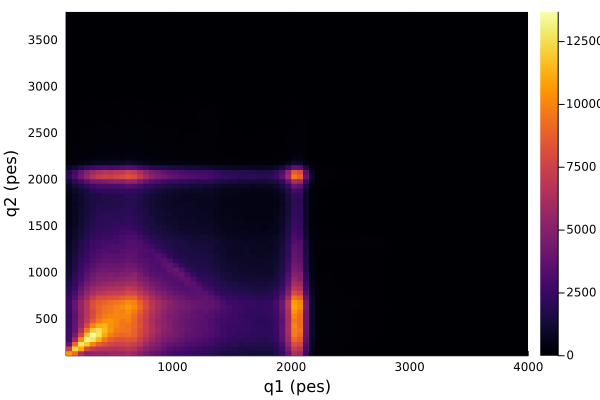

In [25]:
q1min, q1max = (minimum(ndf.q1), maximum(ndf.q1))
q2min, q2max = (minimum(ndf.q2), maximum(ndf.q2))
_, pq1q2 = hist2d(ndf.q1, ndf.q2, 100, "q1 (pes)", "q2 (pes)", q1min, q1max, q2min, q2max)
plot(pq1q2)

In [26]:
interval = ATools.range_bound(conf.qmin, conf.qmax, ATools.OpenBound)
ndfq = filter(x -> broadcast(interval, x.q1) .& broadcast(interval, x.q2), ndf)
println("Photoelectric charge cut leaves ", nrow(ndfq) / nrow(ndf), " of the double interactions, ", nrow(ndfq) / norm, "% of simulated events.")

Photoelectric charge cut leaves 0.020820755371616845 of the double interactions, 0.0037406% of simulated events.


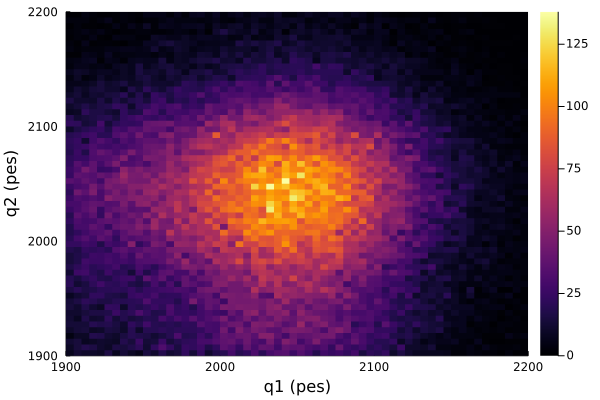

In [27]:
_, pq1q2_f = hist2d(ndfq.q1, ndfq.q2, 100, "q1 (pes)", "q2 (pes)", q1min, q1max, q2min, q2max)
plot(pq1q2_f)

# Combine the two hemispheres for calibration

In [28]:
function combined_std(df::DataFrame, stdz::Symbol, stdphi::Symbol)
  sqrt.(df[!, stdz].^2 + (rmax .* df[!, stdphi]).^2)
end

combined_std (generic function with 1 method)

In [29]:
ring_df = DataFrame(:r => vcat(ndfq.r1, ndfq.r2), :nsipm => vcat(ndfq.nsipm1, ndfq.nsipm2), :zstd => vcat(ndfq.zstd1, ndfq.zstd2), :phistd => vcat(ndfq.phistd1, ndfq.phistd2))
## Add a column with the combination of the two axes
ring_df[!, "stdrad"] = combined_std(ring_df, :zstd, :phistd);

## Correlations between the size of the area of charge seen and the interaction radius

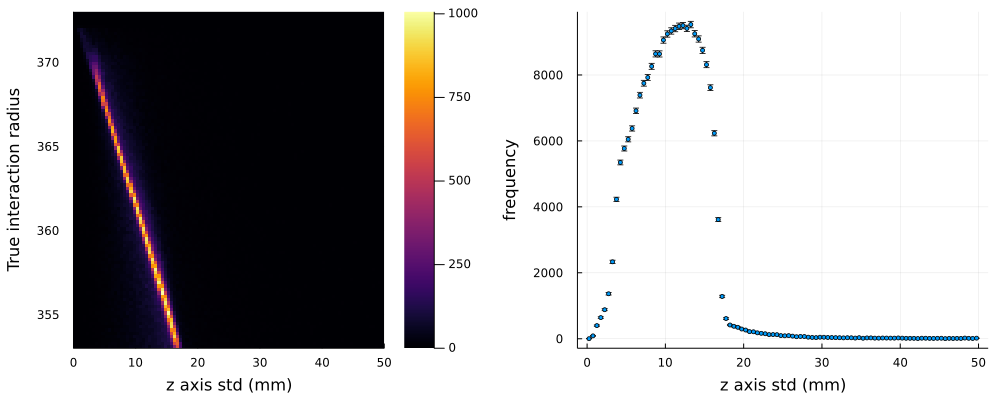

In [30]:
_, pzr = hist2d(ring_df.zstd, ring_df.r, 100, "z axis std (mm)", "True interaction radius", 0.0f0, 50.0f0, 350.0f0, 400.0f0)
hz, pz  = hist1d(ring_df.zstd, "z axis std (mm)", 100, 0.0f0, 50.0f0)
## Need to move some funcitons from ANema to either ATools or NReco
plot(pzr, pz, layout= (1, 2), legend=false, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

In [31]:
zmax, _ = findmax(hz.weights)
useful_bins = findall(x -> x >= 0.1 * zmax, hz.weights)
nbinszpr = useful_bins[end] - useful_bins[1] + 1
minzpr   = edges(hz)[useful_bins[1]]
maxzpr   = edges(hz)[useful_bins[end] + 1]

17.5f0

proportion of selected events in fit range: 0.9628669197454953
Fit parameters: a = 373.80097889112017, b = -1.2165614799893902
Fit errors: a = 0.08361550704765561 b = 0.007673834691771601


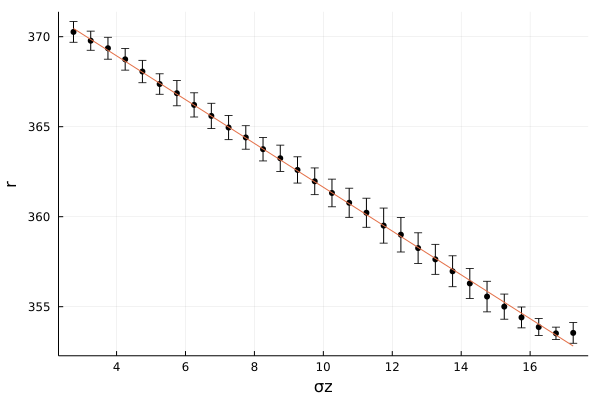

In [32]:
mask_std = (ring_df.zstd .>= minzpr) .& (ring_df.zstd .< maxzpr)
println("proportion of selected events in fit range: ", count(mask_std) / nrow(ring_df))
fzr, pzr = fit_profile(ring_df[mask_std, :zstd], ring_df[mask_std, :r], "σz", "r", "pol1", nbinszpr; ymin=rmin, ymax=rmax, min_proportion=0.1)
fpars = fzr.fitpar
fstds = fzr.fitstd
println("Fit parameters: a = ", fpars[1], ", b = ", fpars[2])
println("Fit errors: a = ", fstds[1], " b = ", fstds[2])
#ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(pzr)

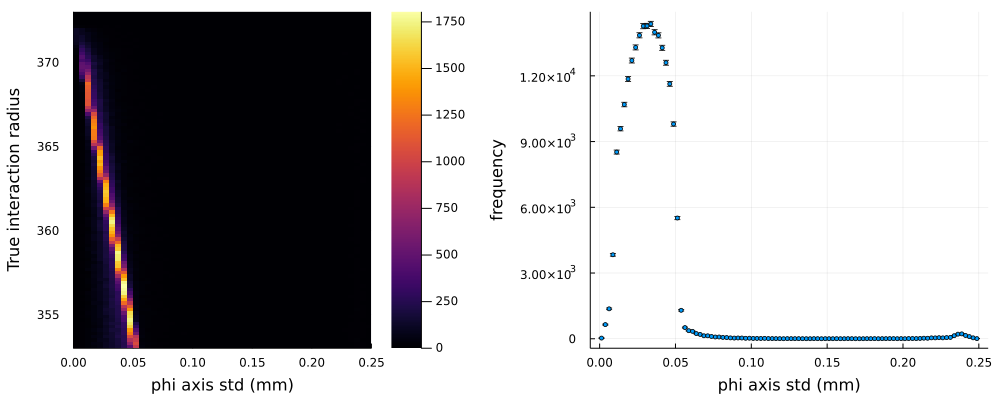

In [33]:
_, ppr = hist2d(ring_df.phistd, ring_df.r, 100, "phi axis std (mm)", "True interaction radius", 0.0f0, 0.25f0, 350.0f0, 400.0f0)
hp, pp  = hist1d(ring_df.phistd, "phi axis std (mm)", 100, 0.0f0, 0.25f0)
## Need to move some funcitons from ANema to either ATools or NReco
plot(ppr, pp, layout= (1, 2), legend=false, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

In [34]:
pmax, _ = findmax(hp.weights)
useful_bins = findall(x -> x >= 0.1 * pmax, hp.weights)
nbinsppr = useful_bins[end] - useful_bins[1] + 1
minppr   = edges(hp)[useful_bins[1]]
maxppr   = edges(hp)[useful_bins[end] + 1]

0.0525f0

proportion of selected events in fit range: 0.926268513072769
Fit parameters: a = 373.1584955730177, b = -390.250532964888
Fit errors: a = 0.08855736889120355 b = 2.7095266075161395


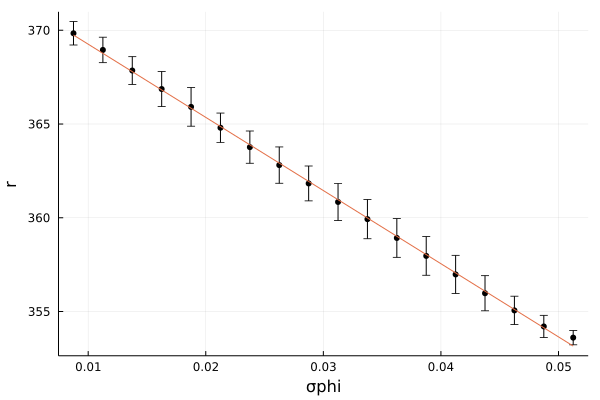

In [35]:
mask_std = (ring_df.phistd .>= minppr) .& (ring_df.phistd .< maxppr)
println("proportion of selected events in fit range: ", count(mask_std) / nrow(ring_df))
fpr, ppr = fit_profile(ring_df[mask_std, :phistd], ring_df[mask_std, :r], "σphi", "r", "pol1", nbinsppr; ymin=rmin, ymax=rmax, min_proportion=0.1)
fpars = fpr.fitpar
fstds = fpr.fitstd
println("Fit parameters: a = ", fpars[1], ", b = ", fpars[2])
println("Fit errors: a = ", fstds[1], " b = ", fstds[2])
#ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(ppr)

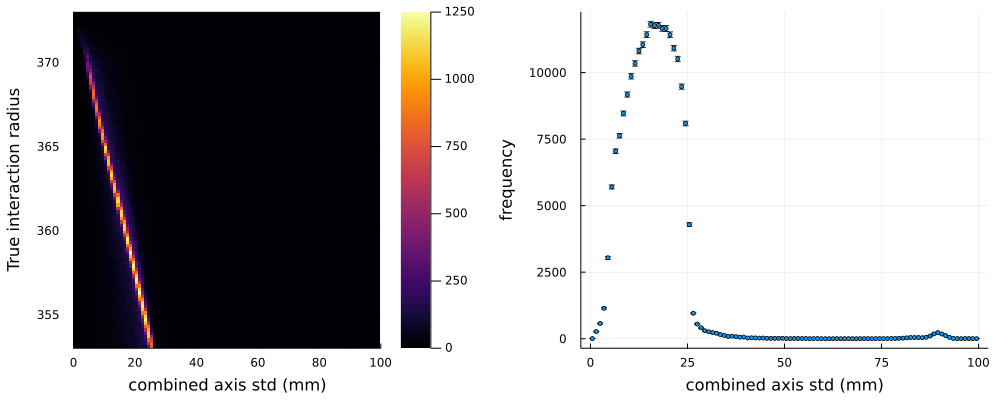

In [36]:
_, pcr = hist2d(ring_df.stdrad, ring_df.r, 100, "combined axis std (mm)", "True interaction radius", 0.0f0, 100.0f0, 350.0f0, 400.0f0)
hc, pc  = hist1d(ring_df.stdrad, "combined axis std (mm)", 100, 0.0f0, 100.0f0)
## Need to move some funcitons from ANema to either ATools or NReco
plot(pcr, pc, layout= (1, 2), legend=false, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

In [37]:
cmax, _ = findmax(hc.weights)
useful_bins = findall(x -> x >= 0.1 * cmax, hc.weights)
nbinscpr = useful_bins[end] - useful_bins[1] + 1
mincpr   = edges(hc)[useful_bins[1]]
maxcpr   = edges(hc)[useful_bins[end] + 1]

26.0f0

proportion of selected events in fit range: 0.9264289151473025
Fit parameters: a = 373.56807398925196, b = -0.7988879907719124
Fit errors: a = 0.04421904979064887 b = 0.0027150986275086835


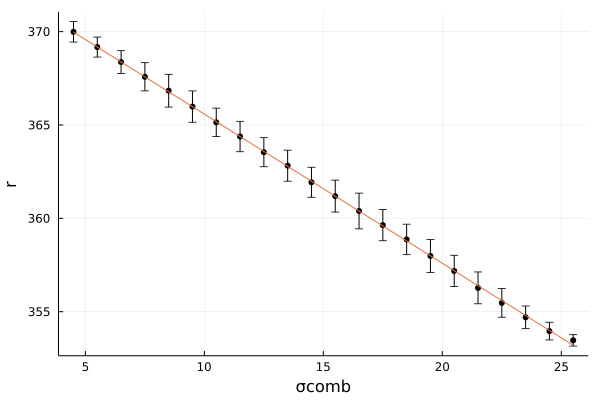

In [38]:
mask_std = (ring_df.stdrad .>= mincpr) .& (ring_df.stdrad .< maxcpr)
println("proportion of selected events in fit range: ", count(mask_std) / nrow(ring_df))
fcr, pcr = fit_profile(ring_df[mask_std, :stdrad], ring_df[mask_std, :r], "σcomb", "r", "pol1", nbinscpr; ymin=rmin, ymax=rmax, min_proportion=0.1)
fpars = fcr.fitpar
fstds = fcr.fitstd
println("Fit parameters: a = ", fpars[1], ", b = ", fpars[2])
println("Fit errors: a = ", fstds[1], " b = ", fstds[2])
#ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(pcr)

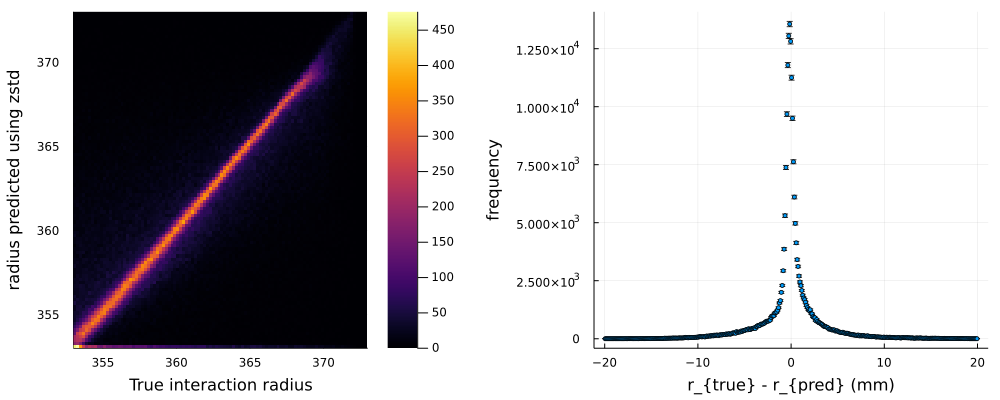

In [39]:
zpredr = ATools.predict_interaction_radius(fzr.g, rmin, rmax)(ring_df.zstd)
_, pRzres = hist2d(ring_df.r, Float32.(zpredr), 100, "True interaction radius", "radius predicted using zstd", rmin - 2.0f0, rmax + 2.0f0, rmin - 2.0f0, rmax + 2.0f0)
hzres, pzres  = hist1d(Float32.(ring_df.r - zpredr), "r_{true} - r_{pred} (mm)", 400, rmin - rmax, rmax - rmin, legend=true)
## Need to move some funcitons from ANema to either ATools or NReco
plot(pRzres, pzres, layout= (1, 2), legend=false, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

Fit result -0.1357134766419022, 0.3547573054919909, 2.430376789756871


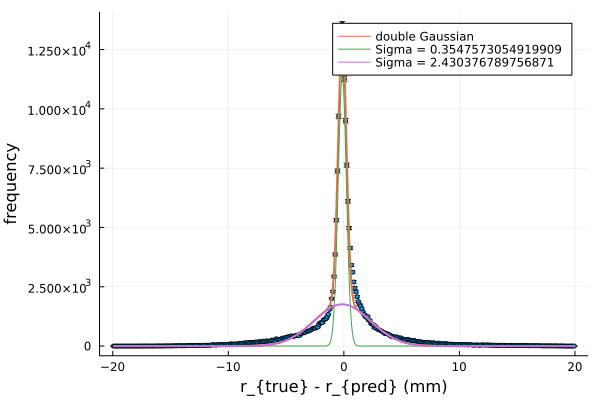

In [40]:
x_vals = ATools.centers(hzres)
imax, xmax, _ = ATools.find_max_xy(x_vals, hzres.weights)
mean_val      = mean(x_vals, FrequencyWeights(hzres.weights))
sigma_centre = std(x_vals[imax-5:imax+5], FrequencyWeights(hzres.weights[imax-5:imax+5]), corrected=true)
sigma_all    = std(x_vals, FrequencyWeights(hzres.weights), corrected=true)
## norm first G, mean, sigma first G, norm second G, sigma second G
lb = [0.0, mean_val - 100, 0.0, 0.0, 0.0]
ub = [sum(hzres.weights) * 100, mean_val + 100, sigma_centre * 100, sum(hzres.weights) * 100, sigma_all * 100]
p0 = [sum(hzres.weights[imax-5:imax+5]), xmax, sigma_centre, sum(hzres.weights), sigma_all]
coeffs = ATools.cfit(ATools.gausscm, Float64.(x_vals), Float64.(hzres.weights), p0, lb, ub)

fitmeanz = coeffs[2]
sigma1   = coeffs[3]
sigma2   = coeffs[5]
println("Fit result ", fitmeanz, ", ", sigma1, ", ", sigma2)
pzres = plot!(pzres, x_vals, ATools.gausscm(x_vals, coeffs), label="double Gaussian", lw=2, fmt=:png)
pzres = plot!(pzres, x_vals, ATools.gausg(coeffs[2], coeffs[3], coeffs[1])(x_vals), label="Sigma = $sigma1", lw=1, fmt=:png)
pzres = plot!(pzres, x_vals, ATools.gausg(coeffs[2], coeffs[5], coeffs[4])(x_vals), label="Sigma = $sigma2", lw=2, fmt=:png)
plot(pzres)

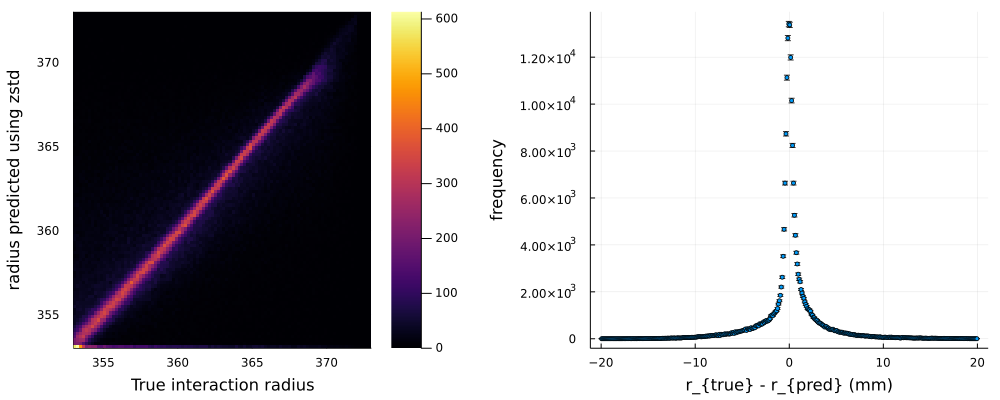

In [41]:
zpredr = ATools.predict_interaction_radius(fzr.g, rmin, rmax, fitmeanz)(ring_df.zstd)
_, pRzres = hist2d(ring_df.r, Float32.(zpredr), 100, "True interaction radius", "radius predicted using zstd", rmin - 2.0f0, rmax + 2.0f0, rmin - 2.0f0, rmax + 2.0f0)
hzres, pzres  = hist1d(Float32.(ring_df.r - zpredr), "r_{true} - r_{pred} (mm)", 400, rmin - rmax, rmax - rmin, legend=true)
## Need to move some funcitons from ANema to either ATools or NReco
plot(pRzres, pzres, layout= (1, 2), legend=false, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

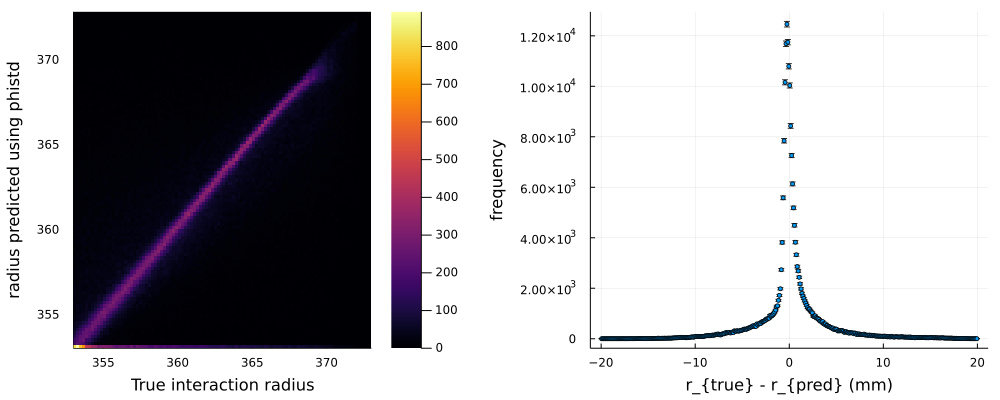

In [42]:
ppredr = ATools.predict_interaction_radius(fpr.g, rmin, rmax)(ring_df.phistd)
_, pRpres = hist2d(ring_df.r, Float32.(ppredr), 100, "True interaction radius", "radius predicted using phistd", rmin - 2.0f0, rmax + 2.0f0, rmin - 2.0f0, rmax + 2.0f0)
hpres, ppres  = hist1d(Float32.(ring_df.r - ppredr), "r_{true} - r_{pred} (mm)", 400, rmin - rmax, rmax - rmin, legend=true)
## Need to move some funcitons from ANema to either ATools or NReco
plot(pRpres, ppres, layout= (1, 2), legend=false, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

Fit result -0.14649202219270113, 0.3939336463438268, 2.8101624636821736


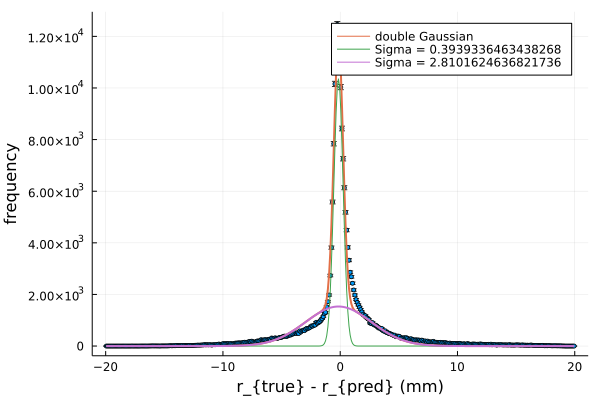

In [43]:
x_vals = ATools.centers(hpres)
imax, xmax, _ = ATools.find_max_xy(x_vals, hpres.weights)
mean_val      = mean(x_vals, FrequencyWeights(hpres.weights))
sigma_centre = std(x_vals[imax-5:imax+5], FrequencyWeights(hpres.weights[imax-5:imax+5]), corrected=true)
sigma_all    = std(x_vals, FrequencyWeights(hpres.weights), corrected=true)
## norm first G, mean, sigma first G, norm second G, sigma second G
lb = [0.0, mean_val - 100, 0.0, 0.0, 0.0]
ub = [sum(hpres.weights) * 100, mean_val + 100, sigma_centre * 100, sum(hzres.weights) * 100, sigma_all * 100]
p0 = [sum(hpres.weights[imax-5:imax+5]), xmax, sigma_centre, sum(hpres.weights), sigma_all]
coeffs = ATools.cfit(ATools.gausscm, Float64.(x_vals), Float64.(hpres.weights), p0, lb, ub)

fitmeanp = coeffs[2]
sigma1   = coeffs[3]
sigma2   = coeffs[5]
println("Fit result ", fitmeanp, ", ", sigma1, ", ", sigma2)
ppres = plot!(ppres, x_vals, ATools.gausscm(x_vals, coeffs), label="double Gaussian", lw=2, fmt=:png)
ppres = plot!(ppres, x_vals, ATools.gausg(coeffs[2], coeffs[3], coeffs[1])(x_vals), label="Sigma = $sigma1", lw=1, fmt=:png)
ppres = plot!(ppres, x_vals, ATools.gausg(coeffs[2], coeffs[5], coeffs[4])(x_vals), label="Sigma = $sigma2", lw=2, fmt=:png)
plot(ppres)

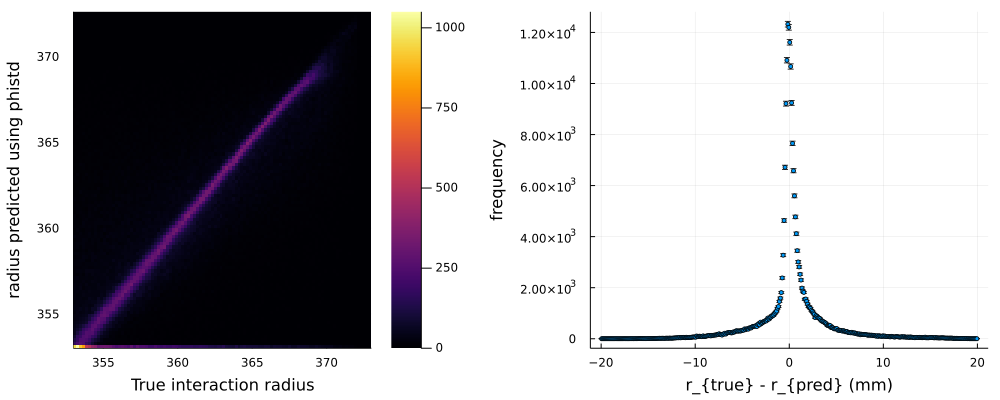

In [44]:
ppredr = ATools.predict_interaction_radius(fpr.g, rmin, rmax, fitmeanp)(ring_df.phistd)
_, pRpres = hist2d(ring_df.r, Float32.(ppredr), 100, "True interaction radius", "radius predicted using phistd", rmin - 2.0f0, rmax + 2.0f0, rmin - 2.0f0, rmax + 2.0f0)
hpres, ppres  = hist1d(Float32.(ring_df.r - ppredr), "r_{true} - r_{pred} (mm)", 400, rmin - rmax, rmax - rmin, legend=true)
## Need to move some funcitons from ANema to either ATools or NReco
plot(pRpres, ppres, layout= (1, 2), legend=false, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

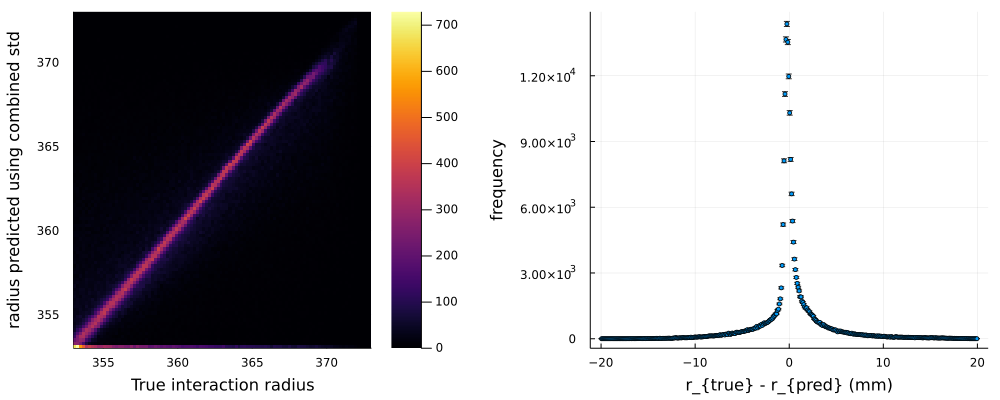

In [45]:
cpredr = ATools.predict_interaction_radius(fcr.g, rmin, rmax)(ring_df.stdrad)
_, pRcres = hist2d(ring_df.r, Float32.(cpredr), 100, "True interaction radius", "radius predicted using combined std", rmin - 2.0f0, rmax + 2.0f0, rmin - 2.0f0, rmax + 2.0f0)
hcres, pcres  = hist1d(Float32.(ring_df.r - cpredr), "r_{true} - r_{pred} (mm)", 400, rmin - rmax, rmax - rmin, legend=true)
## Need to move some funcitons from ANema to either ATools or NReco
plot(pRcres, pcres, layout= (1, 2), legend=false, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

Fit result -0.18674362530024835, 0.3214713340497534, 2.6187731230267377


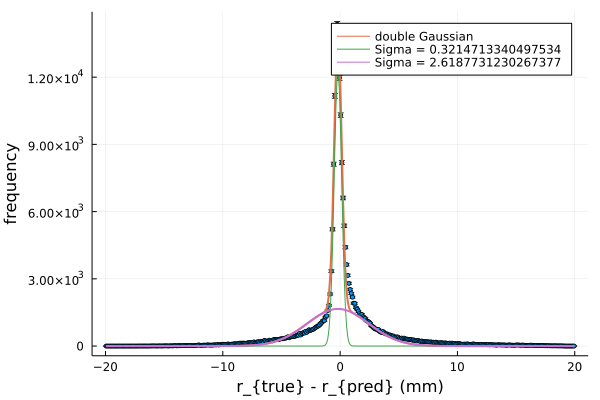

In [46]:
x_vals = ATools.centers(hcres)
imax, xmax, _ = ATools.find_max_xy(x_vals, hcres.weights)
mean_val      = mean(x_vals, FrequencyWeights(hcres.weights))
sigma_centre = std(x_vals[imax-5:imax+5], FrequencyWeights(hcres.weights[imax-5:imax+5]), corrected=true)
sigma_all    = std(x_vals, FrequencyWeights(hcres.weights), corrected=true)
## norm first G, mean, sigma first G, norm second G, sigma second G
lb = [0.0, mean_val - 100, 0.0, 0.0, 0.0]
ub = [sum(hcres.weights) * 100, mean_val + 100, sigma_centre * 100, sum(hcres.weights) * 100, sigma_all * 100]
p0 = [sum(hcres.weights[imax-5:imax+5]), xmax, sigma_centre, sum(hcres.weights), sigma_all]
coeffs = ATools.cfit(ATools.gausscm, Float64.(x_vals), Float64.(hcres.weights), p0, lb, ub)

fitmeanc = coeffs[2]
sigma1   = coeffs[3]
sigma2   = coeffs[5]
println("Fit result ", fitmeanc, ", ", sigma1, ", ", sigma2)
pcres = plot!(pcres, x_vals, ATools.gausscm(x_vals, coeffs), label="double Gaussian", lw=2, fmt=:png)
pcres = plot!(pcres, x_vals, ATools.gausg(coeffs[2], coeffs[3], coeffs[1])(x_vals), label="Sigma = $sigma1", lw=1, fmt=:png)
pcres = plot!(pcres, x_vals, ATools.gausg(coeffs[2], coeffs[5], coeffs[4])(x_vals), label="Sigma = $sigma2", lw=2, fmt=:png)
plot(pcres)

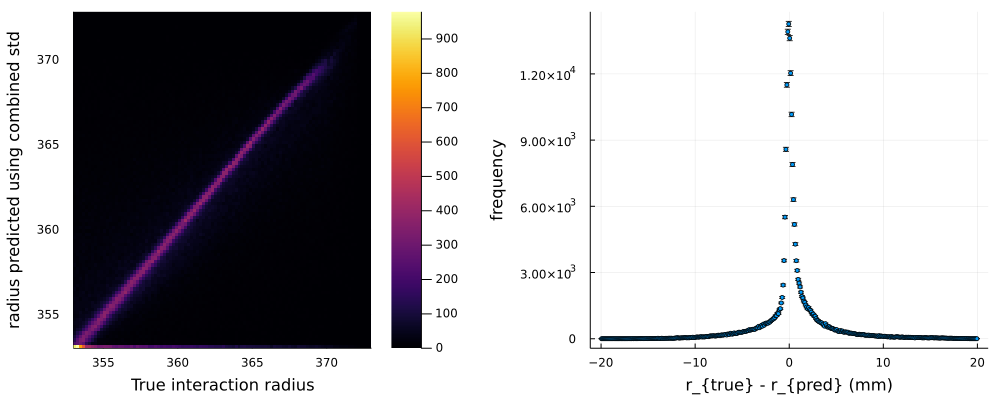

In [47]:
cpredr = ATools.predict_interaction_radius(fcr.g, rmin, rmax, fitmeanc)(ring_df.stdrad)
_, pRcres = hist2d(ring_df.r, Float32.(cpredr), 100, "True interaction radius", "radius predicted using combined std", rmin - 2.0f0, rmax + 2.0f0, rmin - 2.0f0, rmax + 2.0f0)
hcres, pcres  = hist1d(Float32.(ring_df.r - cpredr), "r_{true} - r_{pred} (mm)", 400, rmin - rmax, rmax - rmin, legend=true)
## Need to move some funcitons from ANema to either ATools or NReco
plot(pRcres, pcres, layout= (1, 2), legend=false, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

## Combination slightly better predictor, use it in this version

In [48]:
rpred = ATools.predict_interaction_radius(fcr.g, rmin, rmax, fitmeanc)
ndfq[!, :r1x] = rpred(combined_std(ndfq, :zstd1, :phistd1))
ndfq[!, :r2x] = rpred(combined_std(ndfq, :zstd2, :phistd2));

In [49]:
xp1, yp1, zp1 = ATools.radial_correction(ndfq.xr1, ndfq.yr1, ndfq.zr1, ndfq.r1x);
xp2, yp2, zp2 = ATools.radial_correction(ndfq.xr2, ndfq.yr2, ndfq.zr2, ndfq.r2x);

In [50]:
fg, px1 = fitg1(ndfq.xt1 - xp1, "xt-xp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
println(" σx1 = ", fg.std[1], " mm")
fg, py1 = fitg1(ndfq.yt1 - yp1, "yt-yp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
println(" σy1 = ", fg.std[1], " mm")
fg, pz1 = fitg1(Float64.(ndfq.zt1 - zp1), "zt-zp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
println(" σz1 = ", fg.std[1], " mm")

 σx1 = 0.4308530001005694 mm
 σy1 = 0.4375645798210221 mm
 σz1 = 0.42314046023524576 mm


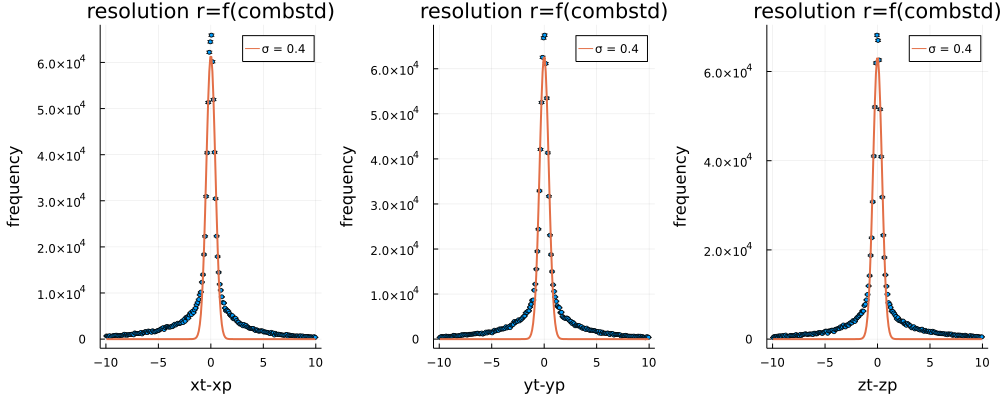

In [51]:
plot(px1, py1, pz1, layout= (1, 3), title="resolution r=f(combstd)", legend=true, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

x-x(rcomb) σ1 = 2.7271340062404783 σ2 = 0.347269409278574
y-y(rcomb) σ1 = 2.642404718653242 σ2 = 0.35505223028205973
z-z(rcomb) σ1 = 2.660698258621097 σ2 = 0.34782701001381683


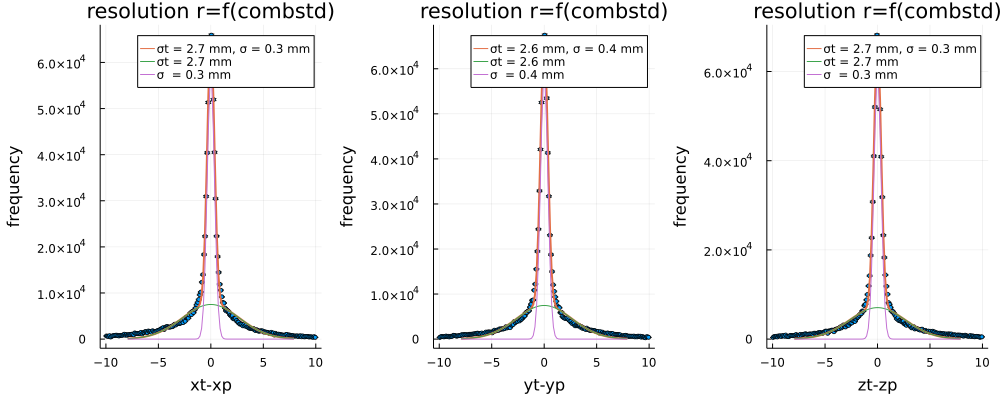

In [52]:
fg, px = fitg2(ndfq.xt1 - xp1, "xt-xp", 200, -10.0, 10.0, 
                      xg1min=-8.0, xg1max=-2.5, 
                      xg2min=-2.5,  xg2max =2.5, 
                      xgmin =-8.0, xgmax  =8.0)
println("x-x(rcomb) σ1 = ", fg.std[1], " σ2 = ", fg.std[2])

fg, py = fitg2(ndfq.yt1 - yp1, "yt-yp", 200, -10.0, 10.0, 
                      xg1min=-8.0, xg1max=-2.5, 
                      xg2min=-2.5,  xg2max =2.5, 
                      xgmin =-8.0, xgmax  =8.0)
println("y-y(rcomb) σ1 = ", fg.std[1], " σ2 = ", fg.std[2])

fg, pz = fitg2(Float64.(ndfq.zt1 - zp1), "zt-zp", 200, -10.0, 10.0, 
                      xg1min=-8.0, xg1max=-2.5, 
                      xg2min=-2.5,  xg2max =2.5, 
                      xgmin =-8.0, xgmax  =8.0)
println("z-z(rcomb) σ1 = ", fg.std[1], " σ2 = ", fg.std[2])
plots_res = plot(px, py, pz, layout= (1, 3), title="resolution r=f(combstd)", legend=true, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

In [53]:

png(plots_res, joinpath(plot_path, "xyz_interaction_resolution"))

In [54]:
## Get the true interaction radius (Why not saved?)
transform!(ndfq, [:xt1, :yt1] => ((x, y) -> sqrt.(x.^2 + y.^2)) => :rt1, [:xt2, :yt2] => ((x, y) -> sqrt.(x.^2 + y.^2)) => :rt2);
units_ndfq = ATools.set_units(ndfq);

first photoelectron, position reco: FWHM = 221.17261644523913, FWHM2 = 35.11086248157906


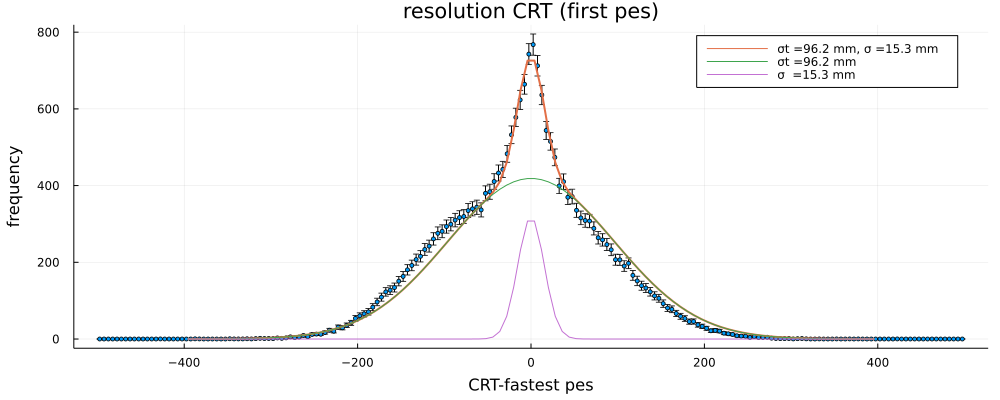

In [55]:
dt = ATools.CRT(units_ndfq, [:t1, :t2], [:rt1, :rt2], rmax)
fg,p = fitg2(dt, "CRT-fastest pes", 200, -500.0, 500.0, xg1min=-400.0, xg1max=-50.0, xg2min=-50.0,  xg2max =50.0, xgmin =-400.0, xgmax  =400.0)
println("first photoelectron, position reco: FWHM = ", 2.3*fg.std[1], ", FWHM2 = ", 2.3*fg.std[2])
best_crt = plot(p, title="resolution CRT (first pes)", legend=true, fmt= :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

In [56]:
png(best_crt, joinpath(plot_path, "crt_limit_truth"))

fastest photoelectron, position reco: FWHM = 243.53635849269827


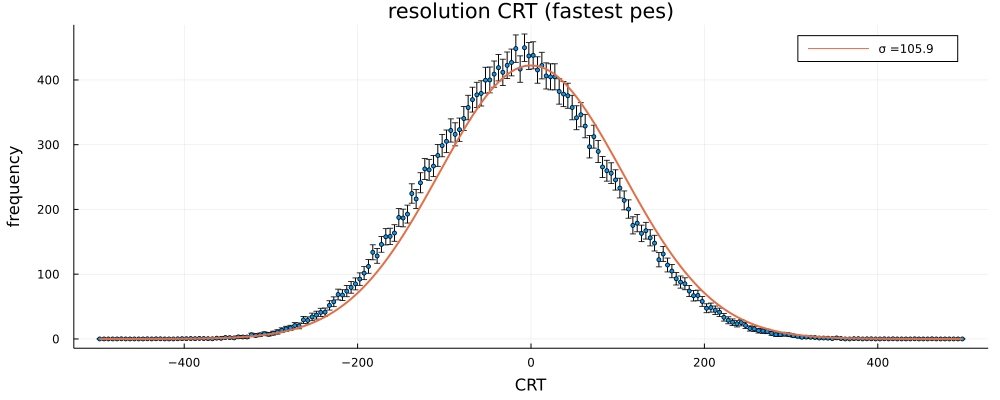

In [57]:
dt = ATools.CRT(units_ndfq, [:tr1, :tr2], [:rt1, :rt2], rmax)
fg, p = fitg1(dt, "CRT", 200, -500.0, 500.0, xgmin=-400.0, xgmax=400.0)
println("fastest photoelectron, position reco: FWHM = ", 2.3*fg.std[1])
fast_crt = plot(p, title="resolution CRT (fastest pes)", legend=true, fmt= :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

In [58]:
png(fast_crt, joinpath(plot_path, "crt_fastSi_rtruth"))

fastest photoelectron, position reco: FWHM = 227.8966554142209


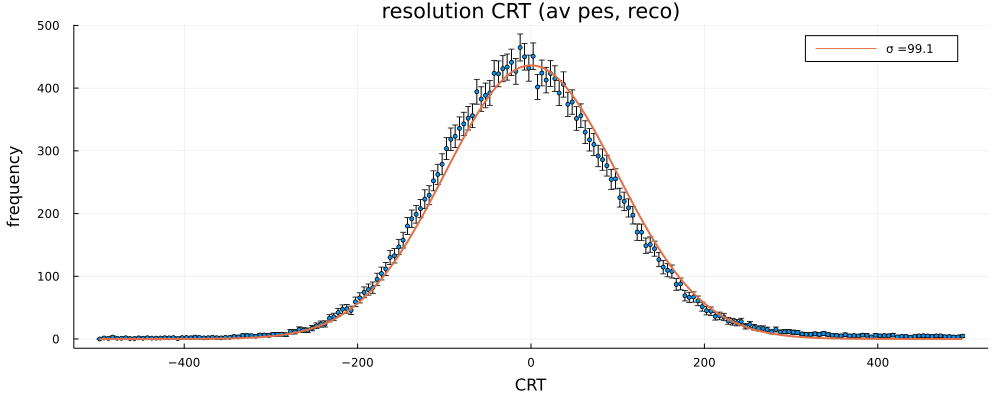

In [59]:
dt = ATools.CRT(units_ndfq, [:ta1, :ta2], [:r1x, :r2x], rmax)
fg, p = fitg1(dt, "CRT", 200, -500.0, 500.0, xgmin=-400.0, xgmax=400.0)
println("fastest photoelectron, position reco: FWHM = ", 2.3*fg.std[1])
reco_crt = plot(p, title="resolution CRT (av pes, reco)", legend=true, fmt= :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

In [60]:
png(reco_crt, joinpath(plot_path, "crt_avSi_recoR"))

# For now we're going to save the calibration constants and calculate and save LOR info here. This should be formalised better.

In [61]:
#xp1, yp1, zp1, xp2, yp2, zp2
mlor_filename = joinpath(plot_path, config[1:end-1] * "_mlor.h5")
## LXe refraction index
nLXe = 1.69
t1   = ATools.interaction_time(units_ndfq, :r1x, :ta1, rmax, nLXe)
t2   = ATools.interaction_time(units_ndfq, :r2x, :ta2, rmax, nLXe)
mLor = ATools.MlemLor.((t2 - t1) ./ps, xp1, yp1, zp1, xp2, yp2, zp2)
ATools.write_lors_hdf5(mlor_filename, mLor)

In [62]:
## Cutre save of calibration info.
if conf.save_cal
  h5open("../config/radius_calibration.h5", "cw") do h5cal
    grp = haskey(h5cal, config) ? h5cal[config] : create_group(h5cal, config)
    attributes(grp)["zstd-bias"]  = fitmeanz
    attributes(grp)["zstd-const"] = fzr.fitpar[1]
    attributes(grp)["zstd-lin"]   = fzr.fitpar[2]
    attributes(grp)["pstd-bias"]  = fitmeanp
    attributes(grp)["pstd-const"] = fpr.fitpar[1]
    attributes(grp)["pstd-lin"]   = fpr.fitpar[2]
    attributes(grp)["cstd-bias"]  = fitmeanc
    attributes(grp)["cstd-const"] = fcr.fitpar[1]
    attributes(grp)["cstd-lin"]   = fcr.fitpar[2]
  end
end
  

-0.7988879907719124

## NEMA 4

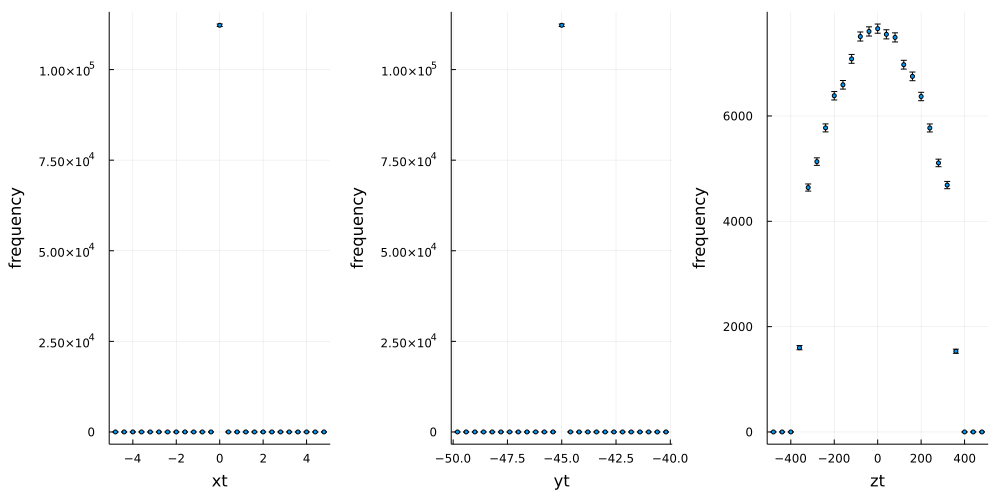

In [64]:
hx,px = hist1d(ndfq.xs, "xt", 25, -5.0f0, 5.0f0, norm=false)
hz,pz = hist1d(ndfq.zs, "zt", 25, -500.0f0, 500.0f0, norm=false)
hy,py = hist1d(ndfq.ys, "yt", 25, -50.0f0, -40.0f0, norm=false)
plot(px,py,pz, layout= (1, 3), legend=false, fmt = :png, size = (1000, 500),
        left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

### Read lors

In [74]:
lor_path = joinpath(in_path, string(split(in_path,"/")[3],"_mlor.h5")) 

"../data/n4-window-dz1m-LXe20mm-4/n4-window-dz1m-LXe20mm-4_mlor.h5"

In [81]:
lors_average_recall = readh5_todf(lor_path, "reco_info","lors");

In [83]:
first(lors_average_recall,5) 

,dx,x1,y1,z1,x2,y2,z2
,Float32,Float32,Float32,Float32,Float32,Float32,Float32
1,-365.376,-201.455,295.005,440.835,167.146,-326.323,-330.731
2,-139.715,-183.989,303.826,307.119,307.202,-173.885,-271.886
3,131.247,-351.237,-35.239,-463.736,360.708,-73.9235,-64.7859
4,-123.161,292.88,200.522,155.43,-258.227,-261.856,-467.888
5,-235.293,348.769,85.5221,-18.5645,-324.134,-166.202,238.962


In [90]:
function distance_lor_to_point(x1::Real,y1::Real,x2::Real,y2::Real,
                               x0::Real=0.0,y0::Real=0.0)

num = abs((x2 - x1) * (y1 - y0) - (x1 - x0) * (y2 - y1))
den = sqrt((x2 -x1)^2 + (y2 - y1)^2)
Float32(num/den)
end

distance_lor_to_point (generic function with 3 methods)

In [91]:
function sinogramdf(ldf)

    # add z, θ and r columns 
    ldf[!, "zl"] = ldf.z1 - ldf.z2;
    ldf[!, "rl"] = distance_lor_to_point.(ldf.x1, ldf.y1, ldf.x2, ldf.y2, 
                                      zeros(nrow(ldf)), zeros(nrow(ldf)) )
    ldf[!, "tl"] = atan.(ldf.x1, ldf.y1)  
    return ldf
end   

sinogramdf (generic function with 1 method)

In [117]:
function xsgrm(df::DataFrame, sgrm="tl"; ntproj::Integer, nbinr=20, rmin=0.0f0, rmax=75.0f0,
               zmin=-350.0f0,zmax=350.0f0)
    
    if sgrm == "tl"
        ht  = hist1d(df.tl, ntproj, -Float32(π), Float32(π))
    else
        ht  = hist1d(df.zl, ntproj, zmin, zmax)
    end
    hte = edges(ht)
    RT = [select_by_column_value_interval(df, 
                                         sgrm, 
                                         hte[i], hte[i+1]) for i in 1:length(hte)-1]
    [hist1d(dfx.rl, nbinr, rmin, rmax) for dfx in RT]
end



xsgrm (generic function with 2 methods)

In [102]:
function stp(hrl::Histogram; i0::Integer = 5, i1::Integer = 15)
    w = Float64.(hrl.weights)
    e = edges(hrl)[1:end-1]
    w0 = w[i0]                        # contents of bin
    w1 = w[i1]
    im, _, wm = find_max_xy(e, w)
    spb = w[i0:i1]
    fxy = gline2p(i0,w0,i1, w1)
    bkg = [fxy(i) for i in i0:i1]
    sgn = spb - bkg
    sgn = [s >0 ? ceil(s) : 0.0 for s in sgn]
    T = sum(sgn)
    P = sum(w)
    S = P - T

    #@info "i0 = %d, im= %d, i1 = %d" i0 im i1
    #@info "w0 = %5.1f, wm= %5.1f, w1 =%5.1f" w0 wm w1

    return S,T,P
end

stp (generic function with 1 method)

In [92]:
sxdf = sinogramdf(lors_average_recall)
first(sxdf,5)

,dx,x1,y1,z1,x2,y2,z2,zl,rl
,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32
1,-365.376,-201.455,295.005,440.835,167.146,-326.323,-330.731,771.566,22.7434
2,-139.715,-183.989,303.826,307.119,307.202,-173.885,-271.886,579.005,89.5275
3,131.247,-351.237,-35.239,-463.736,360.708,-73.9235,-64.7859,-398.95,54.2439
4,-123.161,292.88,200.522,155.43,-258.227,-261.856,-467.888,623.318,34.63
5,-235.293,348.769,85.5221,-18.5645,-324.134,-166.202,238.962,-257.527,42.0984


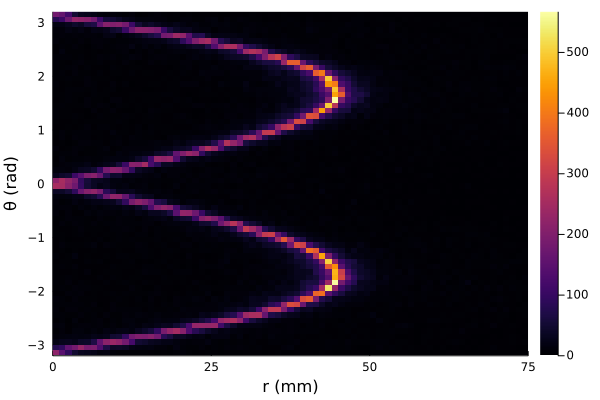

In [93]:
h1,p1 = hist2d(sxdf.rl, sxdf.tl, 100, "r (mm)", "θ (rad)",
               0.0f0, 75.0f0, -Float32(π), Float32(π))
plot(p1, fmt = :png)

In [95]:
rhst =xsgrm(sxdf, "tl", ntproj=4, nbinr=20, rmin=0.0f0, rmax=60.0f0);

In [96]:
PLT=[]
for (i, hst) in enumerate(rhst)
    lbl = string("θ-bin =", string(i))
    _, p = hist1d(hst, lbl)
    push!(PLT,p)
end

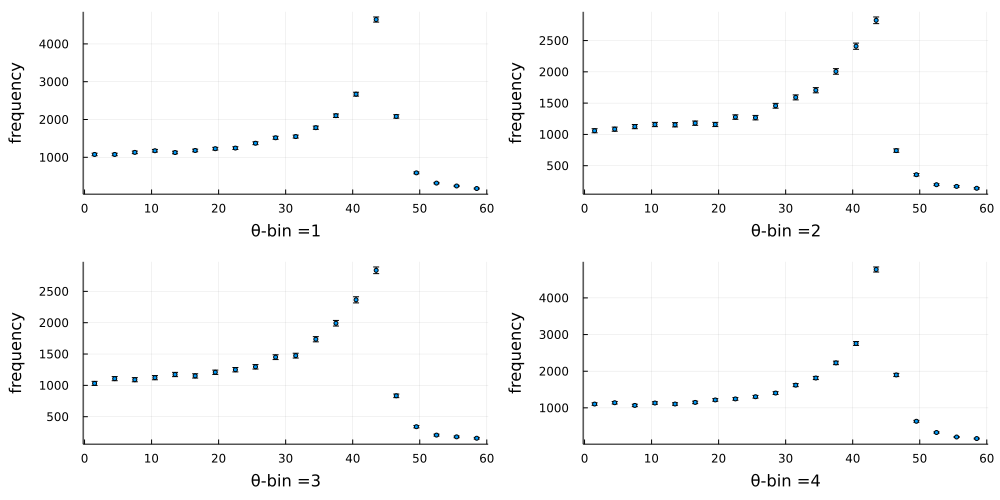

In [97]:
plot(PLT..., layout= (2, 2), legend=false, fmt = :png, size = (1000, 500),
        left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

In [108]:
SOT = []
for (i, hrl) in enumerate(rhst)
    println("θ bin =", i)
    S,T,P = stp(hrl, i0 = 7, i1 = 20)
    push!(SOT, S/T)
    @printf " T = %5.1f S = %5.1f P = %5.1f S/T = %5.1f" T S P S/T
    
end
@printf "\nS/T (average) = %5.1f" mean(SOT)

θ bin =1
 T = 11732.0 S = 16553.0 P = 28285.0 S/T =   1.4θ bin =2
 T = 8387.0 S = 15675.0 P = 24062.0 S/T =   1.9θ bin =3
 T = 7995.0 S = 16000.0 P = 23995.0 S/T =   2.0θ bin =4
 T = 11972.0 S = 16311.0 P = 28283.0 S/T =   1.4
S/T (average) =   1.7

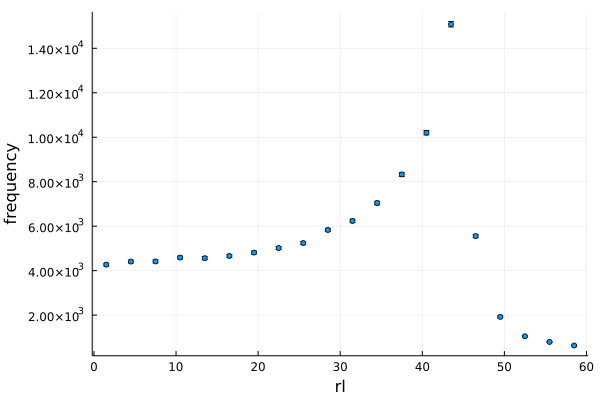

In [110]:
hr,pr = hist1d(sxdf.rl, "rl", 20, 0.0f0, 60.f0)
plot(pr)

In [118]:
zhst =xsgrm(sxdf, "zl", ntproj=4, nbinr=20, rmin=0.0f0, rmax=60.0f0);

In [119]:
PRZ=[]
for (i, hst) in enumerate(zhst)
    lbl = string("z-bin =", string(i))
    _, p = hist1d(hst, lbl)
    push!(PRZ,p)
end

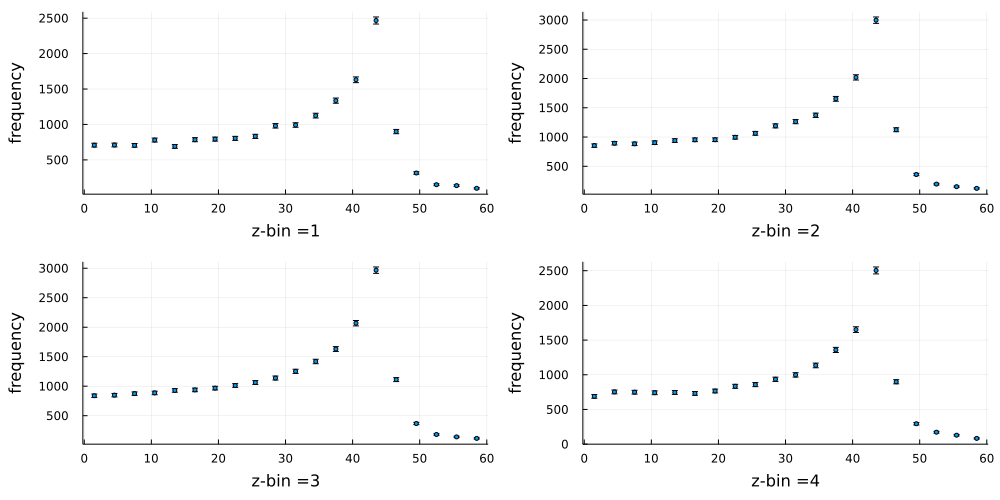

In [120]:
plot(PRZ..., layout= (2, 2), legend=false, fmt = :png, size = (1000, 500),
        left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

In [122]:
SOTZ = []
for (i, hrl) in enumerate(zhst)
    println("z bin =", i)
    S,T,P = stp(hrl, i0 = 7, i1 = 20)
    push!(SOTZ, S/T)
    @printf " T = %5.1f S = %5.1f P = %5.1f S/T = %5.1f" T S P S/T
end
sot = mean(SOTZ)
@printf "\nS/T (average) = %5.1f" sot

z bin =1
 T = 6394.0 S = 10546.0 P = 16940.0 S/T =   1.6z bin =2
 T = 8019.0 S = 12874.0 P = 20893.0 S/T =   1.6z bin =3
 T = 7967.0 S = 12774.0 P = 20741.0 S/T =   1.6z bin =4
 T = 6701.0 S = 10322.0 P = 17023.0 S/T =   1.5
S/T (average) =   1.6

In [123]:
S,T,P = stp(hr, i0 = 7, i1 = 20)
@printf " T = %5.1f S = %5.1f P = %5.1f S/T = %5.1f" T S P S/T
println()
nec = T/(1 + S/T)   
@printf " nec = %5.1f, SNR = %5.1f NEC/P = %5.2f " nec sqrt(nec) nec/P

 T = 40006.0 S = 64619.0 P = 104625.0 S/T =   1.6
 nec = 15297.3, SNR = 123.7 NEC/P =  0.15 

### NEC curves

In [127]:
## Change the configuration .toml to change the input and cuts.
config_file = "../config/cal_n4-20mm-singles.toml"
conf        = from_toml(CalConfig, config_file)

CalConfig("../data/", "n4-window-dz1m-LXe20mm-4-singles", "plot_dir", 1900.0f0, 2200.0f0, true)

In [128]:
## Basic setup: Variables shouold be adjusted for each relevant run
# normalisation: number of decays simulated, should be saved somewhere!
# rmin         : Ring minimum r
# rmax         : Ring maximum r
# in_dir       : directory where the output folders of makenema.jl are.
# config       : subdirectory for input/output
# plot_dir     : base directory for plots
in_dir    = conf.input_dir
config    = conf.conf_dir
plot_dir  = conf.plot_dir
if !isdir(plot_dir)
  mkdir(plot_dir)
end
in_path   = joinpath(in_dir, config)
plot_path = joinpath(plot_dir, config)
if !isdir(plot_path)
  mkdir(plot_path)
end

"plot_dir/n4-window-dz1m-LXe20mm-4-singles"

In [129]:
in_path

"../data/n4-window-dz1m-LXe20mm-4-singles"

In [141]:
function readdf(dir; ext="*.csv")
    files = glob(ext,dir)
    dfs =[DataFrame(CSV.File(file)) for file in files]
    evtdf=vcat(dfs...)
end

readdf (generic function with 2 methods)

In [148]:
sdf = readdf(in_path, ext="*.h5")
xn = names(sdf) 
x = [ sum(col) for col in eachcol(sdf)]
evtdf2 = DataFrame()
for i in 1:length(xn)
    evtdf2[!, xn[i]] = [x[i]]
end
evtdf2

,empty,good-prompt,prompt,single,single-prompt,total
,Int64,Int64,Int64,Int64,Int64,Int64
1,6962257,2401929,2647641,12488697,12123127,22098595


In [152]:
rgp = evtdf2[!, "good-prompt"][1] / evtdf2[!, "total"][1]
rsp = evtdf2[!, "single-prompt"][1] / evtdf2[!, "total"][1]

@printf "\nfraction good prompt = %5.3g " rgp
@printf "\nfraction single prompt = %5.3g " rsp


fraction good prompt = 0.109 
fraction single prompt = 0.549 

## TEMPORARY FIX

In [153]:
dir = "/Users/jj/JuliaProjects/ANema/data/n4-20mm-singles-qcut2"

"/Users/jj/JuliaProjects/ANema/data/n4-20mm-singles-qcut2"

In [155]:
sdf = readdf(dir, ext="*.csv")
xn = names(sdf) 
x = [ sum(col) for col in eachcol(sdf)]
evtdf = DataFrame()
for i in 1:length(xn)
    evtdf[!, xn[i]] = [x[i]]
end
evtdf

,empty,good-prompt,prompt,single,single-prompt,total
,Int64,Int64,Int64,Int64,Int64,Int64
1,9280807,115828,3530160,16653038,2279705,29464005


In [157]:
rgp = evtdf[!, "good-prompt"][1] / evtdf[!, "total"][1]
rsp = evtdf[!, "single-prompt"][1] / evtdf[!, "total"][1]

@printf "\nfraction good prompt = %5.3g " rgp
@printf "\nfraction single prompt = %5.3g " rsp


fraction good prompt = 0.00393 
fraction single prompt = 0.0774 

In [163]:
L = 700.0 * mm # length of nema4 phantom
d = 203.0 * mm # diameter of nema4 phantom
V = π*(d/2.0)^2 * L 
VmL = uconvert(cm^3, V) / cm^3
@printf " Phantom: L(mm) = %5.1f d (mm) = %5.1f V ( mL) =%5.1f" L/mm d/mm VmL


 Phantom: L(mm) = 700.0 d (mm) = 203.0 V ( mL) =22655.8

In [164]:
kBq=1e+3
A = 10 * Unitful.kBq/cm^3
N = A * V
@printf "\n Activity (kBq/mL) = %5.2f  N (kcps) =%5.2g" A/(Unitful.kBq/cm^3) N/Unitful.kBq


 Activity (kBq/mL) = 10.00  N (kcps) =2.3e+05

In [165]:
AA = LinRange(0.0, 15.0, 200)
Act = AA * Unitful.kBq/cm^3;

In [166]:
NkBq = uconvert.(Unitful.kBq, Act * V) /Unitful.kBq;

In [167]:
pok1(λ::Real) = exp(-λ) * (1.0 + λ)

pok1 (generic function with 1 method)

#### pok1 gives the Poisson probability for k=0, 1 given  λ  

- In the plot below, the probability that k was 0 or 1 if we measure 0 is 1. The probability that K = 0,1 if we measure 2.5 is ~25 % and so on.

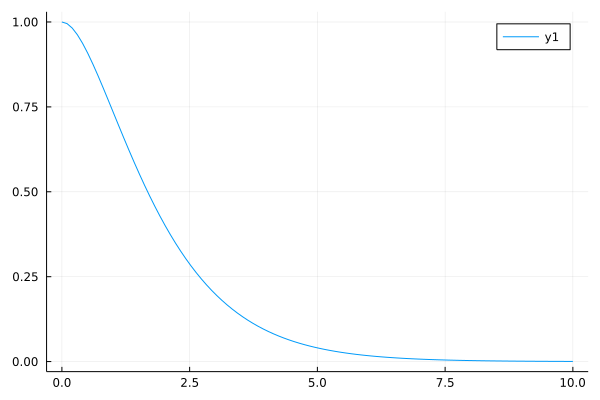

In [168]:
X = LinRange(0.0, 10., 100)
plot(X, pok1.(X))

    **pdt(rkcps::Real, wmus::Real)**

Given an activity rkcps (in kcps) and a dead time wmus (in mus), the average number
of events in that window is kcps/(1/wmus) = kcps * wmus.

In [170]:
function pdt(rkcps::Real, wmus::Real)
    λ = rkcps * wmus * 1e-3  # λ = rate/(1/w) = rate * w where rate in kcps, w in mus
    return pok1(λ)
end

pdt (generic function with 2 methods)

#### NEC curve

In [171]:
function cnec(n_kcps::Real, 
    eff_gp::Real, 
    eff_sp::Real, 
    SOT::Real       =1.6, 
    eff_cwns::Real  = 1e-9,
    deadt_mus::Real = 0.6)

# n_kcps is the number of counts in kcps 
# eff_gp is the efficiency for good prompts
# eff_sp is the efficiency for single prompts
# SOT = S/T, the ratio of plots to trues 
# eff_cwns is the coincidence window in ns. Since rates come in kcps multiply by 10^3

eff_w =  eff_cwns *1e+3
nT = n_kcps * eff_gp               # number of good coincidences in scanner
nS = nT * SOT                      # number of scatters in scanner
n1 = n_kcps * eff_sp                # number of singles in scanner
nR = 2 * n1^2 * eff_w              # number of randoms
ntot = nT + nS + nR

prob = pdt(ntot, deadt_mus)
nT   *= prob
nS   *= prob
#nR   *= prob
ntot *= prob

nec = nT / (1.0 + nS/nT + nR/nT)   # nec


return nT, nS, nR, ntot, nec, prob
end

cnec (generic function with 4 methods)

- Given an activity rkcps (in kcps) and a dead time wmus (in mus), the average number
of events in that window is:

λ  = kcps * wmus, and the probability
for k=0,1 is pok1(λ)

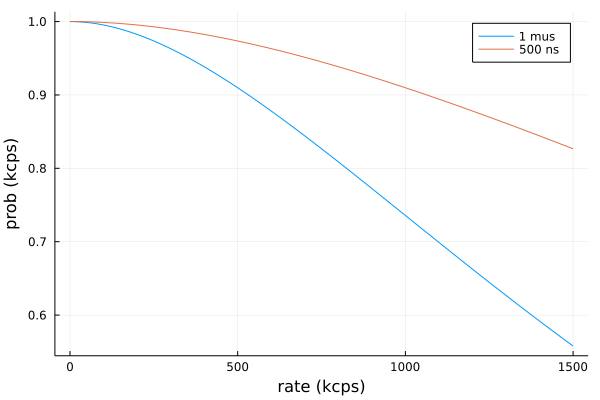

In [172]:
T = LinRange(0.0, 1500.0, 200)
p1 = plot(T, pdt.(T, (1.0,)), label="1 mus")
p2 = plot!(p1, T, pdt.(T, (0.5,)), label="500 ns")
xlabel!("rate (kcps)")
ylabel!("prob (kcps)")

In [173]:
function unzipn(rs)
    nT, nS, nR, ntot, nec, prob =  collect(zip(rs...))
    return collect(nT), collect(nS), collect(nR), collect(ntot),collect(nec), collect(prob)
end

unzipn (generic function with 1 method)

In [174]:
res = cnec.(NkBq, (rgp,), (rsp,), (sot,), (1e-9,), (0.5,))
nT, nS, nR, ntot, nec, prob = unzipn(res);

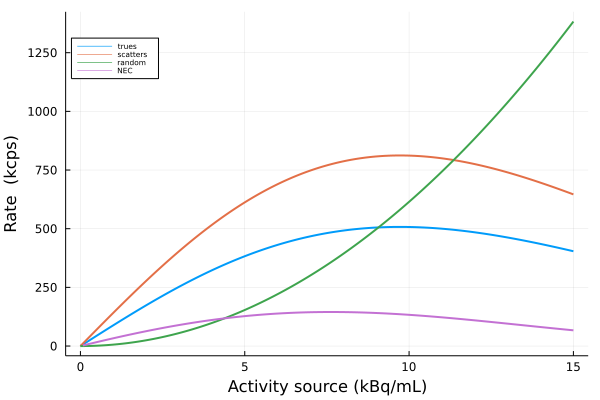

In [175]:
#p = scatter(AA,ntot, yerr = sqrt.(ntot), makersize=1, label="total", 
#legend=(0.1,0.9), legendfontsize=5, fmt = :png,)
p = plot(AA,nT,  lw=2, label="trues", 
legend=(0.1,0.9), legendfontsize=5, fmt = :png,)
p = plot!(p,AA,nS, lw=2, label="scatters", 
legend=(0.1,0.9), legendfontsize=5, fmt = :png,)
p = plot!(p,AA,nR, lw=2, label="random", 
legend=(0.1,0.9), legendfontsize=5, fmt = :png,)
p = plot!(p,AA,nec, lw=2, label="NEC", 
legend=(0.1,0.9), legendfontsize=5, fmt = :png,)
xlabel!("Activity source (kBq/mL)")
ylabel!("Rate  (kcps)")